# WiDS Datathon 2021 - Diabetes Classification EDA

Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. Patient's history of comorbidity can significantly affect both the treatment options and their outcome. The task is to build a machine learning model to determine the probability that a patient admitted to an ICU has a comorbid medical condition, in this particular case, diabetes mellitus.  We use data collected from the first 24 hours of intensive care, such as the patient's vital functions and lab tests to predict a binary classification label indicating the presence or absence of diabetes mellitus. With the help of this model, the hope is to achieve more positive medical outcome for ICU patients.   

## Library Imports

In [176]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [177]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.impute import SimpleImputer

In [178]:
# seed for the random number generator
SEED = 1729

## Exploratory Data Analysis

### Basic Information

In [179]:
# load training data set from csv file into pandas data frame
train = pd.read_csv('TrainingWiDS2021.csv', usecols=range(1,181))
train.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,31.0,...,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,0,NaN,NaN,NaN,88.0,48.0,88.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,1,8.0,62.0,30.0,48.0,42.0,48.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,0,NaN,NaN,NaN,99.0,57.0,99.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 180 entries, encounter_id to diabetes_mellitus
dtypes: float64(157), int64(17), object(6)
memory usage: 178.7+ MB


In [181]:
print(train.shape)

(130157, 180)


In [182]:
train.drop_duplicates(inplace=True)
print(train.shape)

(130157, 180)


No duplicate rows in the data set.

In [183]:
train.select_dtypes(include='int64').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   encounter_id                 130157 non-null  int64
 1   hospital_id                  130157 non-null  int64
 2   elective_surgery             130157 non-null  int64
 3   icu_id                       130157 non-null  int64
 4   readmission_status           130157 non-null  int64
 5   apache_post_operative        130157 non-null  int64
 6   arf_apache                   130157 non-null  int64
 7   intubated_apache             130157 non-null  int64
 8   ventilated_apache            130157 non-null  int64
 9   aids                         130157 non-null  int64
 10  cirrhosis                    130157 non-null  int64
 11  hepatic_failure              130157 non-null  int64
 12  immunosuppression            130157 non-null  int64
 13  leukemia                     

1. No null values in these columns.
2. encounter_id, hospital_id and icu_id are identifiers.
3. diabetes_mellitus is the binary classification label.
4. Rest of the columns have binary values.

In [184]:
train.select_dtypes(include='float64').iloc[:, 0:50].head()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max
0,68.0,22.732803,180.3,0.541667,73.9,2.3,113.0,502.01,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0
1,77.0,27.421875,160.0,0.927778,70.2,NaN,108.0,203.01,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,NaN,NaN,159.0
2,25.0,31.952749,172.7,0.000694,95.3,NaN,122.0,703.03,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,NaN,NaN,NaN,88.0,48.0,88.0,48.0,96.0,68.0,NaN,NaN,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,NaN,NaN,148.0
3,81.0,22.635548,165.1,0.000694,61.7,NaN,203.0,1206.03,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,60.0,30.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,8.0,62.0,30.0,48.0,42.0,48.0,42.0,116.0,92.0,92.0,52.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,164.0,78.0,158.0
4,19.0,NaN,188.0,0.073611,NaN,NaN,119.0,601.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,NaN,NaN,NaN,99.0,57.0,99.0,57.0,89.0,60.0,NaN,NaN,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,NaN,NaN,147.0


In [185]:
train.select_dtypes(include='float64').iloc[:, 0:50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        125169 non-null  float64
 1   bmi                        125667 non-null  float64
 2   height                     128080 non-null  float64
 3   pre_icu_los_days           130157 non-null  float64
 4   weight                     126694 non-null  float64
 5   albumin_apache             51994 non-null   float64
 6   apache_2_diagnosis         128472 non-null  float64
 7   apache_3j_diagnosis        129292 non-null  float64
 8   bilirubin_apache           47597 non-null   float64
 9   bun_apache                 104746 non-null  float64
 10  creatinine_apache          105275 non-null  float64
 11  fio2_apache                30437 non-null   float64
 12  gcs_eyes_apache            127967 non-null  float64
 13  gcs_motor_apache           12

1. Almost all columns have null values.
2. apache_2_diagnosis and apache_3j_dignosis are codes (not numbers) but have numeric data type.

In [186]:
train.select_dtypes(include='float64').iloc[:, 50:100].head()

,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max
0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN
1,67.0,159.0,67.0,36.3,35.1,NaN,NaN,61.0,48.0,61.0,48.0,114.0,100.0,NaN,NaN,85.0,57.0,85.0,57.0,31.0,28.0,95.0,70.0,NaN,NaN,95.0,71.0,95.0,71.0,36.3,36.3,1.6,1.6,0.5,0.5,11.0,9.0,8.6,8.0,0.71,0.56,145.0,128.0,27.0,26.0,11.3,11.1,36.9,36.1,1.3
2,105.0,148.0,105.0,37.0,36.7,NaN,NaN,88.0,58.0,88.0,58.0,96.0,78.0,NaN,NaN,91.0,83.0,91.0,83.0,20.0,16.0,98.0,91.0,NaN,NaN,148.0,124.0,148.0,124.0,36.7,36.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,84.0,158.0,84.0,38.0,34.8,62.0,44.0,62.0,44.0,NaN,NaN,100.0,96.0,92.0,71.0,92.0,71.0,NaN,NaN,12.0,11.0,100.0,99.0,136.0,106.0,136.0,106.0,NaN,NaN,35.6,34.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185.0,88.0,NaN,NaN,11.6,8.9,34.0,25.9,1.6
4,120.0,147.0,120.0,37.2,36.7,NaN,NaN,99.0,68.0,99.0,68.0,89.0,76.0,NaN,NaN,104.0,92.0,104.0,92.0,NaN,NaN,100.0,100.0,NaN,NaN,130.0,120.0,130.0,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
train.select_dtypes(include='float64').iloc[:, 50:100].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   d1_sysbp_min               129886 non-null  float64
 1   d1_sysbp_noninvasive_max   128534 non-null  float64
 2   d1_sysbp_noninvasive_min   128534 non-null  float64
 3   d1_temp_max                125663 non-null  float64
 4   d1_temp_min                125663 non-null  float64
 5   h1_diasbp_invasive_max     25328 non-null   float64
 6   h1_diasbp_invasive_min     25328 non-null   float64
 7   h1_diasbp_max              124630 non-null  float64
 8   h1_diasbp_min              124630 non-null  float64
 9   h1_diasbp_noninvasive_max  118818 non-null  float64
 10  h1_diasbp_noninvasive_min  118818 non-null  float64
 11  h1_heartrate_max           126083 non-null  float64
 12  h1_heartrate_min           126083 non-null  float64
 13  h1_mbp_invasive_max        25

All of these columns have null values.

In [188]:
train.select_dtypes(include='float64').iloc[:, 100:].head()

,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.3,3.5,3.5,557.0,487.0,4.2,3.8,145.0,145.0,23.3,12.7,NaN,NaN,NaN,NaN,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.1,NaN,NaN,198.0,43.0,5.0,3.5,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
train.select_dtypes(include='float64').iloc[:, 100:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Data columns (total 57 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   d1_inr_min            48944 non-null   float64
 1   d1_lactate_max        34654 non-null   float64
 2   d1_lactate_min        34654 non-null   float64
 3   d1_platelets_max      111600 non-null  float64
 4   d1_platelets_min      111600 non-null  float64
 5   d1_potassium_max      117611 non-null  float64
 6   d1_potassium_min      117611 non-null  float64
 7   d1_sodium_max         116887 non-null  float64
 8   d1_sodium_min         116887 non-null  float64
 9   d1_wbc_max            112728 non-null  float64
 10  d1_wbc_min            112728 non-null  float64
 11  h1_albumin_max        11152 non-null   float64
 12  h1_albumin_min        11152 non-null   float64
 13  h1_bilirubin_max      10296 non-null   float64
 14  h1_bilirubin_min      10296 non-null   float64
 15  

In [190]:
train.select_dtypes(include='object').head()

,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,Caucasian,M,Floor,Floor,admit,CTICU
1,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
2,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
3,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU
4,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU


In [191]:
train.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   ethnicity              128570 non-null  object
 1   gender                 130091 non-null  object
 2   hospital_admit_source  96959 non-null   object
 3   icu_admit_source       129917 non-null  object
 4   icu_stay_type          130157 non-null  object
 5   icu_type               130157 non-null  object
dtypes: object(6)
memory usage: 7.0+ MB


## Distributions

### Distribution of Categorical Features

In [192]:
# percentage of nulls in categorical columns

X = train.select_dtypes(include=['object'])
s = (X.isnull().sum()/ X.shape[0])*100
print(s)

ethnicity                 1.219297
gender                    0.050708
hospital_admit_source    25.506120
icu_admit_source          0.184393
icu_stay_type             0.000000
icu_type                  0.000000
dtype: float64


In [193]:
for col in train.select_dtypes(include='object').columns:
    print(train[col].value_counts())

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
Native American        915
Name: ethnicity, dtype: int64
M    70518
F    59573
Name: gender, dtype: int64
Emergency Department    51258
Operating Room          13757
Floor                   11324
Direct Admit             8253
Recovery Room            4563
Other Hospital           2417
Acute Care/Floor         2097
Step-Down Unit (SDU)     1607
PACU                     1031
Other ICU                 283
Chest Pain Center         253
ICU to SDU                 62
ICU                        37
Observation                10
Other                       7
Name: hospital_admit_source, dtype: int64
Accident & Emergency         76846
Operating Room / Recovery    27436
Floor                        21459
Other Hospital                3464
Other ICU                      712
Name: icu_admit_source, dtype: int64
admit       124741
transfer      4801
readmit        61

1. There are numerous unique values in categorical columns.
2. Categories are imbalanced in most columns. There are no obvious categories to collapse. 

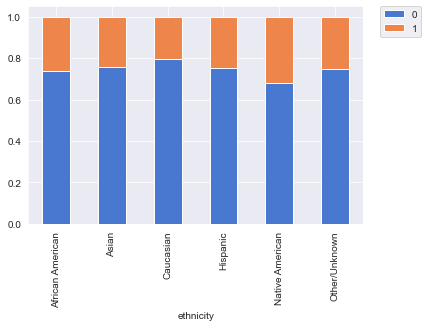

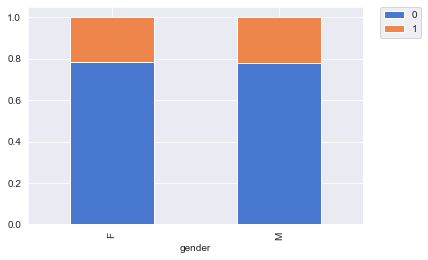

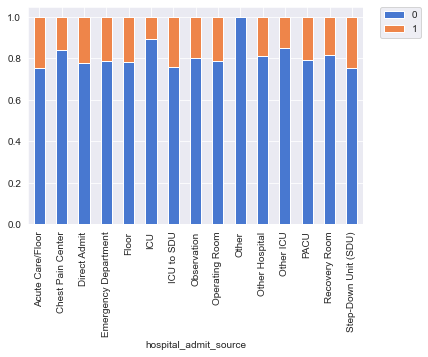

In [194]:
# how are categorical columns related to the classification label?

cat_df = train.select_dtypes(include=['object'])
cat_columns = cat_df.columns

for col in cat_columns[:3]: 
    ctab = pd.crosstab(cat_df[col], train['diabetes_mellitus'], normalize='index')
    ctab.plot.bar(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)
    plt.show()

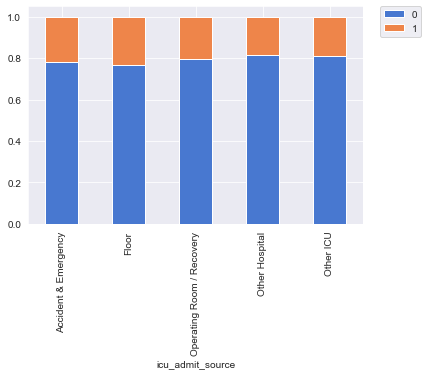

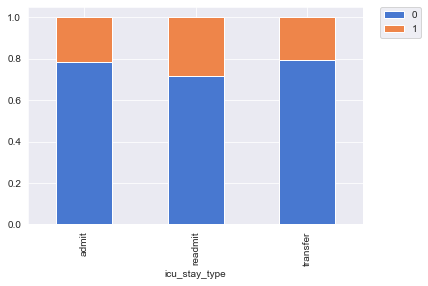

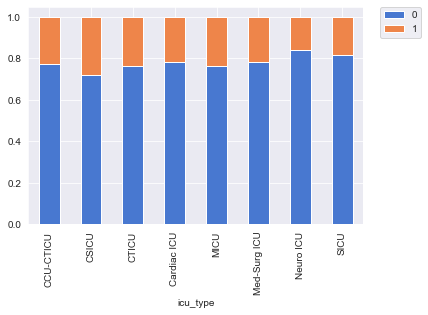

In [195]:
# how are categorical columns related to the classification label?

for col in cat_columns[3:]: 
    ctab = pd.crosstab(cat_df[col], train['diabetes_mellitus'], normalize='index')
    ctab.plot(kind='bar', stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0)
    plt.show()

Categorical features appear to have some relationship with the label column. This relationship is the weakest with gender column.

In [196]:
binary_cols = list(train.select_dtypes(include='int64'))

binary_cols.remove('hospital_id')
binary_cols.remove('icu_id')
binary_cols.remove('encounter_id')
print(binary_cols)

['elective_surgery', 'readmission_status', 'apache_post_operative', 'arf_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'diabetes_mellitus']


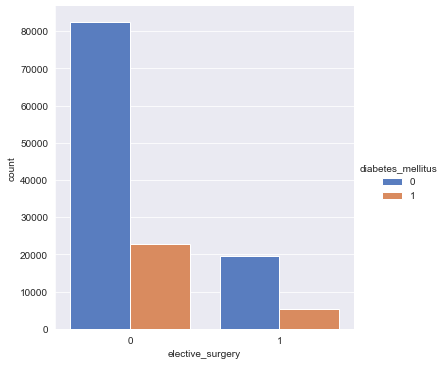

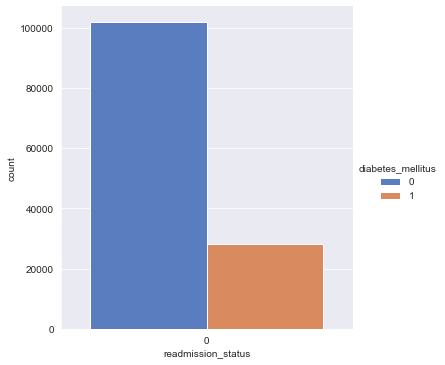

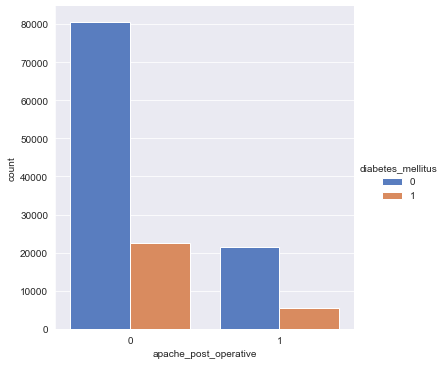

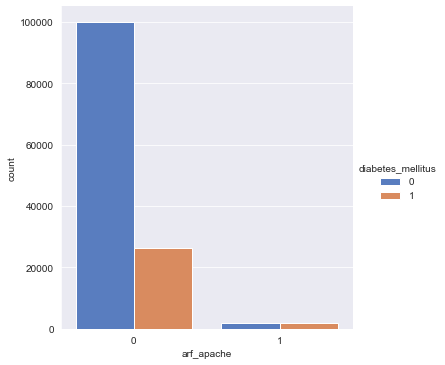

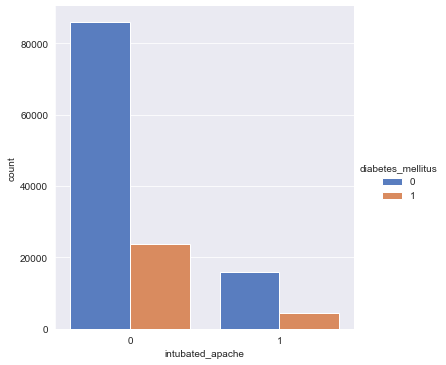

In [197]:
# how are binary categorical columns related to the class label?
for col in binary_cols[:5]:
    sns.catplot(x=col, hue='diabetes_mellitus', kind='count', data=train[binary_cols])
    plt.show()

In [198]:
train['readmission_status'].value_counts()

0    130157
Name: readmission_status, dtype: int64

readmission_status has the same value(0) for all rows. It is useless and must be removed.

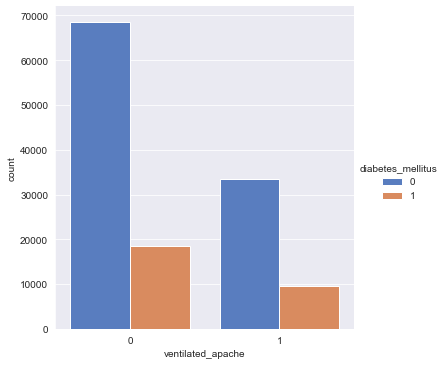

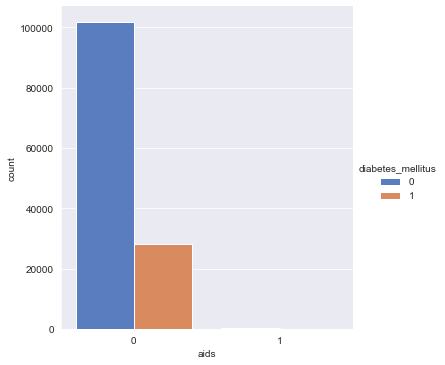

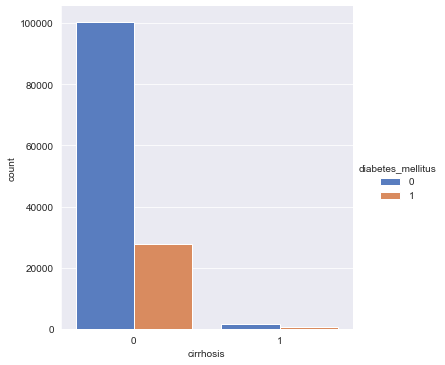

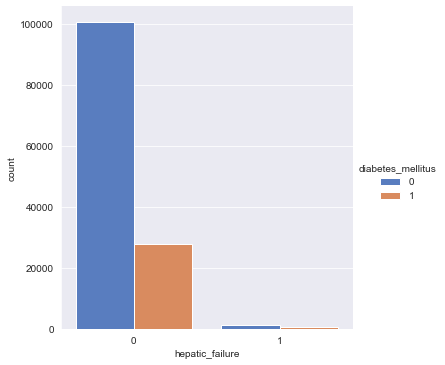

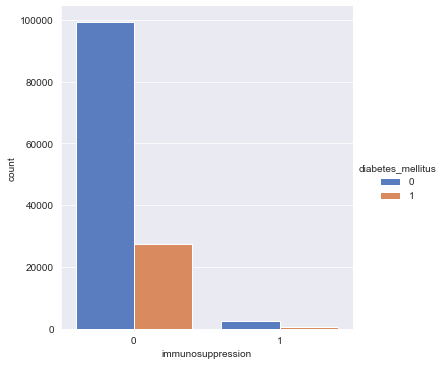

In [199]:
# how are binary categorical columns related to the class label?
for col in binary_cols[5:10]:
    sns.catplot(x=col, hue='diabetes_mellitus', kind='count', data=train[binary_cols])
    plt.show()

In [200]:
train['aids'].value_counts()

0    130023
1       134
Name: aids, dtype: int64

In [201]:
pd.crosstab(train.aids, train.diabetes_mellitus, normalize='index')

diabetes_mellitus,0,1
aids,,
0,0.783577,0.216423
1,0.917910,0.082090


Binary variable aids has highly imbalanced categories. Extremely few rows with aids=1. This may not be a useful predictor.

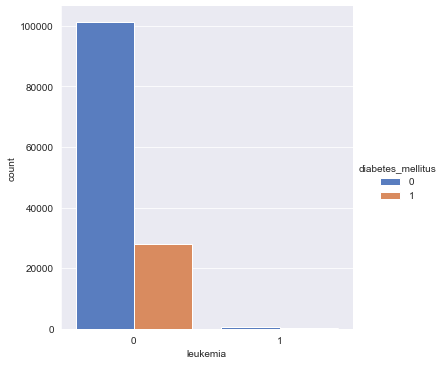

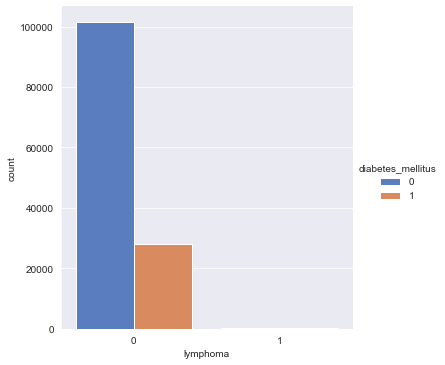

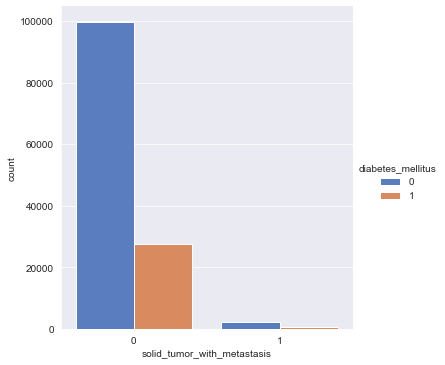

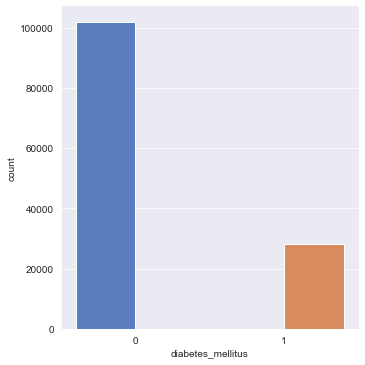

In [202]:
# how are binary categorical columns related to the class label?
for col in binary_cols[10:]:
    sns.catplot(x=col, hue='diabetes_mellitus', kind='count', data=train[binary_cols])
    plt.show()

In [203]:
# calculate percentage distribution of the two class labels

train['diabetes_mellitus'].value_counts(normalize=True)

0    0.783715
1    0.216285
Name: diabetes_mellitus, dtype: float64

Classification label: diabetes_mellitus=0 - patient does not have the disease.
diabetes_mellitus=1 - patient has the disease.
The two classes are highly imbalanced. 78.4% rows of value 0 makes it the majority class - most patients in the dataset do not have the disease.

In [204]:
pd.crosstab(train.lymphoma, train.diabetes_mellitus, normalize='index')

diabetes_mellitus,0,1
lymphoma,,
0,0.783708,0.216292
1,0.785321,0.214679


In [205]:
train['lymphoma'].value_counts()

0    129612
1       545
Name: lymphoma, dtype: int64

In [206]:
train['leukemia'].value_counts()

0    129206
1       951
Name: leukemia, dtype: int64

In [207]:
pd.crosstab(train.leukemia, train.diabetes_mellitus, normalize='index')

diabetes_mellitus,0,1
leukemia,,
0,0.783841,0.216159
1,0.766562,0.233438


Both leukemia and lymphoma have highly imbalanced categories.

In [208]:
# how is apache_3j_diagnosis related to the class label?

diagnosis = train['apache_3j_diagnosis'].astype('category')

ctab = pd.crosstab(diagnosis, train['diabetes_mellitus'])
print(ctab)

diabetes_mellitus     0   1
apache_3j_diagnosis        
0.01                  1   1
0.02                  0   1
0.03                  1   0
0.04                  4   1
0.06                  2   0
...                  ..  ..
2201.01              17   7
2201.02              12   4
2201.03              13   1
2201.04               5   1
2201.05              71  15

[400 rows x 2 columns]


In [209]:
train['apache_3j_diagnosis'].isnull().sum()

865

In [210]:
train['apache_3j_diagnosis'].min()

0.01

In [211]:
train[train.apache_3j_diagnosis < 101].shape

(820, 180)

In [212]:
train[train.apache_3j_diagnosis > 2202].shape

(0, 180)

Valid range for apache_3j_diagnosis codes: 101-2201.
Valid range for apache_2_diagnosis codes is same as 3j codes followed by 2 decimal digits.
820 rows have invalid 3j codes. 865 rows have null values for the code.

In [213]:
train['apache_2_diagnosis'].value_counts()

113.0    16402
301.0     9858
302.0     8904
112.0     5981
308.0     5855
124.0     5548
117.0     5290
122.0     5206
303.0     5072
304.0     4594
110.0     4395
203.0     3860
106.0     3537
121.0     3431
202.0     3408
114.0     3298
305.0     3111
123.0     2918
119.0     2712
102.0     2631
307.0     2629
118.0     2338
120.0     1994
108.0     1668
214.0     1656
109.0     1440
105.0     1369
218.0     1086
213.0     1041
207.0      973
306.0      830
217.0      802
219.0      714
209.0      645
101.0      605
104.0      580
103.0      487
115.0      392
107.0      300
116.0      279
215.0      215
208.0      214
212.0      138
216.0       66
Name: apache_2_diagnosis, dtype: int64

In [214]:
train['apache_2_diagnosis'].isnull().sum()

1685

Lot of nulls in apache_2_diagnosis. Appears to be a useless column because these values indicate primary diagnosis like 3j codes. The secondary diagnosis codes are part of 3j codes (2 decimal digits.)

In [215]:
bad_label = train[(train.apache_3j_diagnosis >= 701) & (train.apache_3j_diagnosis < 703) & (train.diabetes_mellitus == 0) ]

In [216]:
bad_label.shape

(1235, 180)

823 rows have incompatible 3j diagnosis code and diabetes class label. 701 and 702 are diabetes diagnosis codes.

In [217]:
bad_label.tail(10)

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
127966,234638,7,45.0,36.383365,0,African American,M,167.6,Emergency Department,Accident & Emergency,1106,admit,MICU,0.106944,0,102.2,3.5,123.0,702.01,0,0,0.3,36.0,1.56,0.25,3.0,6.0,0.0,5.0,377.0,102.0,36.0,0,135.0,21.1,21.1,115.0,7.149,37.0,135.0,36.8,NaN,0,13.5,NaN,NaN,115.0,59.0,115.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,375.000,359.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.1,21.1,7.149,7.149,115.0,115.0,460.0,460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
128026,244911,7,87.0,30.870895,0,Other/Unknown,F,152.4,NaN,Accident & Emergency,1104,admit,Cardiac ICU,0.052083,0,71.7,NaN,307.0,701.02,0,0,NaN,106.0,5.54,NaN,4.0,5.0,0.0,3.0,239.0,131.0,32.0,0,102.0,NaN,NaN,NaN,NaN,56.0,137.0,36.7,525.0528,0,10.5,NaN,NaN,71.0,58.0,71.0,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
128094,192845,170,40.0,27.421861,0,African American,F,162.6,Emergency Department,Accident & Emergency,1108,admit,Med-Surg ICU,0.266667,0,72.5,NaN,307.0,701.02,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,4.0,171.0,38.0,NaN,0,175.0,NaN,NaN,NaN,NaN,52.0,NaN,36.2,1350.9504,0,NaN,NaN,NaN,136.0,45.0,136.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0
128492,165082,170,53.0,25.790584,0,Caucasian,F,165.1,Emergency Department,Accident & Emergency,1108,admit,Med-Surg ICU,0.138889,0,70.3,2.5,307.0,701.01,0,0,1.1,30.0,1.39,NaN,3.0,6.0,0.0,4.0,473.0,136.0,20.0,0,54.0,NaN,NaN,NaN,NaN,33.0,129.0,36.8,2430.8640,0,11.0,NaN,NaN,81.0,50.0,81.0,50.0,...,30.0,30.0,8.1,8.1,1.39,1.39,695.045,473.0,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,2.5,129.0,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
128786,267146,7,58.0,31.949043,0,Caucasian,M,177.8,Emergency Department,Accident & Emergency,1104,admit,Cardiac ICU,0.054167,0,101.0,NaN,307.0,701.02,0,0,NaN,8.0,0.67,NaN,4.0,5.0,0.0,3.0,126.0,119.0,42.0,0,115.0,NaN,NaN,NaN,NaN,60.0,134.0,36.9,2094.3360,0,12.9,83.0,53.0,79.0,57.0,79.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.3,14.3,45.0,45.0,NaN,NaN,NaN,NaN,246.0,246.0,NaN,NaN,NaN,NaN,12.9,12.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0

In [218]:
# all rows where 3j diagnosis is diabetes

diabetes3j = train[(train.apache_3j_diagnosis >= 701) & (train.apache_3j_diagnosis < 703)]

In [219]:
diabetes3j.shape

(3650, 180)

In [220]:
diabetes3j.groupby(by='diabetes_mellitus').size()

diabetes_mellitus
0    1235
1    2415
dtype: int64

In [221]:
bad_label[bad_label.glucose_apache >= 200].head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
971,208049,81,57.0,26.557721,0,Hispanic,F,167.6,Floor,Floor,90,admit,Med-Surg ICU,0.120833,0,74.6,3.3,123.0,702.01,0,0,1.1,26.0,1.63,NaN,4.0,6.0,0.0,4.0,598.7,88.0,NaN,0,60.0,NaN,NaN,NaN,NaN,48.0,158.0,36.6,NaN,0,NaN,NaN,NaN,76.0,53.0,76.0,53.0,...,26.0,26.0,9.1,9.1,1.63,1.63,695.045,670.0,13.0,13.0,NaN,NaN,NaN,NaN,1.2,1.2,1.9,1.9,NaN,NaN,2.9,2.9,153.0,153.0,NaN,NaN,25.0,25.0,7.28,7.28,88.0,88.0,NaN,NaN,25.0,25.0,7.28,7.28,88.0,88.0,NaN,NaN,0,0,0,0,0,0,0,0
3608,257281,118,40.0,NaN,0,Hispanic,M,167.6,Emergency Department,Accident & Emergency,100,admit,Neuro ICU,0.001389,0,NaN,3.1,123.0,702.01,0,0,0.5,19.0,1.66,NaN,4.0,6.0,0.0,5.0,299.0,110.0,38.4,0,114.0,NaN,NaN,NaN,NaN,27.0,139.0,36.4,NaN,0,8.0,NaN,NaN,81.0,57.0,81.0,57.0,...,19.0,19.0,7.6,7.6,1.66,1.66,347.000,274.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.5,142.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
5547,193620,31,68.0,38.153922,0,Caucasian,M,165.1,NaN,Accident & Emergency,83,admit,Med-Surg ICU,0.001389,0,104.0,NaN,123.0,702.01,0,0,NaN,40.0,1.70,NaN,4.0,6.0,0.0,5.0,598.7,114.0,NaN,0,65.0,NaN,NaN,NaN,NaN,18.0,152.0,36.3,NaN,0,NaN,NaN,NaN,111.0,53.0,111.0,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
5897,150610,151,23.0,22.818251,0,Hispanic,M,170.2,Emergency Department,Accident & Emergency,109,admit,Med-Surg ICU,0.032639,0,66.1,2.9,123.0,702.01,0,0,0.5,6.0,0.44,NaN,4.0,6.0,0.0,5.0,290.0,116.0,31.8,0,135.0,NaN,NaN,NaN,NaN,31.0,134.0,36.3,NaN,0,10.3,NaN,NaN,101.0,66.0,101.0,66.0,...,6.0,6.0,7.6,7.6,0.53,0.53,259.000,236.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1,3.1,135.0,135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
7756,193478,81,26.0,21.290656,0,Caucasian,M,172.7,Emergency Department,Accident & Emergency,90,admit,Med-Surg ICU,0.000694,0,63.5,4.1,123.0,702.01,0,0,0.8,18.0,1.26,NaN,4.0,6.0,0.0,5.0,407.0,144.0,NaN,0,118.0,NaN,NaN,NaN,NaN,29.0,136.0,36.4,NaN,0,NaN,NaN,NaN,103.0,59.0,103.0,59.0,...,18.0,18.0,8.2,8.2,1.26,1.26,544.000,385.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,137.0,137.0,NaN,NaN,18.4,14.9,7.24,7.24,122.0,122.0,610.0,604.227778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [222]:
diabetes3j[diabetes3j.glucose_apache < 199]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
4898,277397,81,50.0,24.017768,0,African American,F,162.6,Emergency Department,Accident & Emergency,90,admit,Med-Surg ICU,0.009028,0,63.5,NaN,307.0,701.02,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,4.0,98.0,126.0,NaN,0,154.0,NaN,NaN,NaN,NaN,60.0,NaN,37.0,NaN,0,NaN,NaN,NaN,143.0,65.0,143.0,65.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
5785,210019,118,39.0,23.765432,0,Caucasian,M,180.0,Emergency Department,Accident & Emergency,97,admit,MICU,0.006250,0,77.0,NaN,123.0,702.01,0,0,NaN,9.0,1.11,NaN,4.0,6.0,0.0,5.0,96.0,152.0,37.6,0,64.0,NaN,NaN,NaN,NaN,22.0,135.0,36.9,NaN,0,11.5,NaN,NaN,92.0,56.0,92.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,217.0,201.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
6145,265713,83,52.0,15.810528,0,Caucasian,M,170.2,NaN,Floor,95,admit,Med-Surg ICU,1.027778,0,45.8,2.5,307.0,701.02,0,0,3.7,13.0,1.14,0.6,1.0,4.0,0.0,1.0,116.0,153.0,36.6,1,53.0,30.0,30.0,122.0,7.350,59.0,140.0,36.3,NaN,1,15.4,NaN,NaN,78.0,46.0,78.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,106.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,30.0,7.350,7.350,122.0,122.0,203.333333,203.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0
7049,188182,81,82.0,22.332902,0,Caucasian,M,180.3,NaN,Accident & Emergency,90,admit,Med-Surg ICU,0.001389,0,72.6,3.7,307.0,701.02,0,0,1.0,14.0,0.74,NaN,4.0,6.0,0.0,4.0,98.0,178.0,36.9,0,131.0,NaN,NaN,NaN,NaN,55.0,143.0,36.3,NaN,0,7.3,NaN,NaN,99.0,67.0,99.0,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
9674,246923,89,60.0,NaN,0,Caucasian,M,NaN,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.004167,0,113.8,3.4,307.0,701.02,0,0,1.3,24.0,1.10,NaN,1.0,4.0,0.0,1.0,151.0,47.0,40.2,0,156.0,NaN,NaN,NaN,NaN,56.0,138.0,36.3,191.4624,0,10.5,87.0,73.0,104.0,74.0,104.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

Lot of rows with normal/low apache_glucose value have diabetes 3j diagnosis code.

In [223]:
bad_label[bad_label.d1_glucose_min >= 200]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
8226,214055,129,24.0,38.046032,0,Caucasian,M,190.50,Emergency Department,Accident & Emergency,135,admit,Med-Surg ICU,0.196528,0,138.07,3.5,123.0,702.01,0,0,0.5,26.0,1.40,NaN,4.0,6.0,0.0,5.0,338.0,169.0,37.6,0,124.0,NaN,NaN,NaN,NaN,46.0,130.0,36.70,4222.108800,0,20.52,NaN,NaN,102.0,87.0,102.0,87.0,...,26.0,26.0,8.6,8.600,1.40,1.40,337.000,337.0,9.0,9.0,16.5,16.5,45.4,45.4,NaN,NaN,NaN,NaN,282.0,282.0,4.4,4.4,130.0,130.0,20.52,20.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
8237,166083,89,64.0,34.910960,0,Caucasian,M,185.40,Floor,Accident & Emergency,133,admit,Med-Surg ICU,0.084722,0,120.00,4.3,123.0,702.01,0,0,NaN,80.0,2.40,0.21,4.0,6.0,0.0,5.0,598.7,96.0,38.7,0,121.0,36.0,36.0,85.0,7.480,38.0,117.0,36.61,5353.084800,1,7.80,NaN,NaN,94.0,62.0,94.0,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,1.20,4.6,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,36.0,7.480,7.480,85.0,85.0,404.761905,404.761905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
8476,206671,89,55.0,33.309250,0,Other/Unknown,M,177.80,Direct Admit,Accident & Emergency,133,admit,Med-Surg ICU,0.008333,0,105.30,3.5,123.0,702.01,0,0,0.2,86.0,3.70,0.32,4.0,6.0,0.0,5.0,598.7,97.0,NaN,0,58.0,42.4,42.4,96.0,7.271,32.0,137.0,36.80,766.454400,0,NaN,NaN,NaN,75.0,54.0,75.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.6,12.6,37.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN,5.4,5.4,134.0,134.0,NaN,NaN,53.1,42.4,7.271,7.194,96.0,96.0,300.000000,300.000000,53.1,53.100,7.194,7.194,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
9671,273166,198,71.0,29.038834,0,Caucasian,M,177.80,Emergency Department,Accident & Emergency,125,admit,Med-Surg ICU,0.238194,0,91.80,NaN,123.0,702.01,0,0,NaN,26.0,2.20,NaN,1.0,4.0,0.0,1.0,305.0,104.0,36.9,0,70.0,NaN,NaN,NaN,NaN,25.0,141.0,39.40,1177.718400,1,14.80,NaN,NaN,93.0,69.0,93.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
10102,164184,140,68.0,27.808340,0,Caucasian,F,165.10,Emergency Department,Accident & Emergency,126,admit,Med-Surg ICU,0.000000,0,75.80,NaN,307.0,701.01,0,0,NaN,27.0,1.00,NaN,4.0,6.0,0.0,5.0,347.0,112.0,NaN,0,51.0,NaN,NaN,NaN,NaN,59.0,136.0,36.60,NaN,0,NaN,NaN,NaN,48.0,34.0,48.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,317.000,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,32.0,7.330,7

Lot of rows have erroneous 3j and 2 diagnosis codes, especially those for diabetes. 

In [224]:
train['hospital_id'].nunique()

204

In [225]:
train['icu_id'].nunique()

328

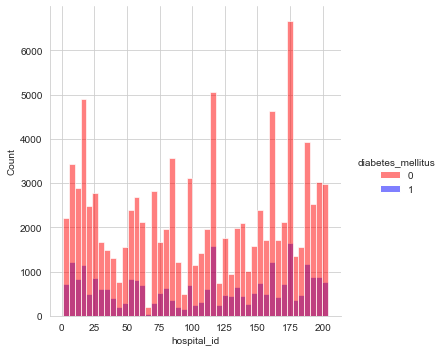

In [226]:
# are hospital_id and icu_id related to the class label?
sns.set_style('whitegrid')
custom_palette = ['red', 'blue']
sns.set_palette(custom_palette)
sns.displot(train, x='hospital_id', hue='diabetes_mellitus')
plt.show()

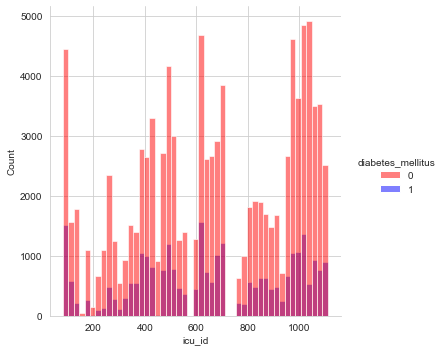

In [227]:
sns.displot(train, x='icu_id', hue='diabetes_mellitus')
plt.show()

Both hospital_id and icu_id, which are identifiers, have a strong relationship with the class label.

In [228]:
train.hospital_id.value_counts()

118    4306
19     3885
188    3075
86     2962
7      2944
       ... 
23        7
95        6
93        6
130       2
25        2
Name: hospital_id, Length: 204, dtype: int64

In [229]:
train.icu_id.value_counts()

1019    1344
646     1312
653     1296
876     1280
413     1219
        ... 
365        2
302        2
603        2
241        2
989        2
Name: icu_id, Length: 328, dtype: int64

hospital_id and icu_id both have very high cardinality and highly imbalanced category levels.

### Distribution of Numerical Features

In [230]:
train.select_dtypes(include='float64').iloc[:, 0:50].describe()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max
count,125169.000000,125667.000000,128080.000000,130157.000000,126694.000000,51994.000000,128472.000000,129292.000000,47597.000000,104746.000000,105275.000000,30437.000000,127967.000000,127967.000000,129448.000000,127967.000000,115461.000000,129848.000000,103399.000000,129737.000000,30437.000000,30437.000000,30437.000000,30437.000000,129349.000000,105638.00000,123546.000000,66990.000000,100682.000000,35089.000000,35089.000000,129880.000000,129880.000000,128521.000000,128521.000000,129895.000000,129895.000000,35289.000000,35289.000000,129830.000000,129830.000000,127929.000000,127929.000000,129474.000000,129474.000000,129625.000000,129625.000000,35119.000000,35119.000000,129886.000000
mean,61.995103,29.110260,169.607219,0.839933,83.791104,2.886149,185.492683,565.994296,1.201222,25.718070,1.481629,0.595735,3.488290,5.484828,0.011441,4.030203,160.141416,99.854530,32.975817,87.193046,42.161246,42.161246,132.061737,7.352154,25.150603,137.94526,36.420638,1800.803417,12.187662,79.261563,46.969706,88.575516,49.862989,88.729344,49.917492,103.296794,70.408530,114.432769,62.211596,104.228522,64.353462,104.183969,64.384111,28.719388,12.690841,99.276104,90.366087,153.285373,93.637604,148.231680
std,16.822880,8.262776,10.833085,2.485337,24.963063,0.689812,85.858208,466.510850,2.351994,20.690041,1.543535,0.262922,0.939831,1.271039,0.106349,1.538528,90.701327,30.759505,6.834576,41.908109,12.267414,12.267414,84.958826,0.098423,15.024730,5.30384,0.857584,1456.551481,6.931023,21.693320,12.736433,20.162800,13.397152,20.155701,13.427746,21.982940,17.141875,49.182744,17.845442,20.910213,15.433092,20.802509,15.458592,10.567866,5.046519,1.722287,10.150349,31.482818,24.596108,25.897117
min,0.000000,14.844926,137.200000,-0.250000,38.600000,1.200000,101.000000,0.010000,0.100000,4.000000,0.300000,0.210000,1.000000,1.000000,0.000000,1.000000,39.000000,30.000000,16.200000,40.000000,18.000000,18.000000,31.000000,6.960540,4.000000,117.00000,32.100000,0.000000,0.900000,37.000000,5.000000,46.000000,13.000000,46.000000,13.000000,58.000000,0.000000,38.000000,2.000000,60.000000,22.000000,60.000000,22.000000,14.000000,0.000000,0.000000,0.000000,71.000000,10.000000,90.000000
25%,52.000000,23.598006,162.500000,0.045833,66.500000,2.400000,113.000000,204.010000,0.400000,13.000000,0.710000,0.400000,3.000000,6.000000,0.000000,4.000000,97.000000,87.000000,28.000000,54.000000,34.500000,34.500000,77.000000,7.301000,11.000000,135.00000,36.200000,799.048800,7.500000,65.000000,40.000000,75.000000,41.000000,75.000000,41.000000,88.000000,60.000000,89.000000,54.000000,90.000000,54.000000,90.000000,54.000000,22.000000,10.000000,99.000000,89.000000,133.000000,80.000000,130.000000
50%,64.000000,27.564749,170.100000,0.155556,80.000000,2.900000,122.000000,409.020000,0.700000,19.000000,0.970000,0.500000,4.000000,6.000000,0.000000,5.000000,133.000000,104.000000,33.100000,66.000000,40.000000,40.000000,104.000000,7.360000,27.000000,138.00000,36.500000,1454.976000,10.470000,76.000000,46.000000,86.000000,50.000000,87.000000,50.000000,101.000000,70.000000,101.000000,62.000000,102.000000,64.000000,102.000000,64.000000,26.000000,13.000000,100.000000,93.000000,150.000000,92.000000,146.000000
75%,75.000000,32.803127,177.

1. Variance and means of these columns differ from each other by order of magnitude. The values need to be standardized.
2. All values are positive except pre_icu_los_days.

In [231]:
train[train.pre_icu_los_days < 0].head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
294,207141,83,74.0,44.370252,0,Caucasian,F,149.9,Emergency Department,Accident & Emergency,95,admit,Med-Surg ICU,-0.132639,0,99.7,NaN,110.0,104.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,193.0,65.0,NaN,0,108.0,NaN,NaN,NaN,NaN,48.0,NaN,37.7,NaN,0,NaN,NaN,NaN,80.0,56.0,80.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.8,3.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,1
310,229555,118,73.0,NaN,0,Caucasian,M,167.6,Direct Admit,Accident & Emergency,114,admit,CCU-CTICU,-0.215278,0,NaN,NaN,110.0,104.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,94.0,NaN,0,67.0,NaN,NaN,NaN,NaN,38.0,NaN,36.4,NaN,0,NaN,80.0,64.0,79.0,59.0,79.0,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,1,0
1344,189482,118,81.0,NaN,1,Caucasian,F,157.4,Operating Room,Operating Room / Recovery,92,admit,CTICU,-0.004167,0,NaN,NaN,202.0,1205.01,1,0,NaN,30.0,1.09,0.36,4.0,6.0,0.0,5.0,144.0,52.0,31.3,0,52.0,49.0,49.0,257.0,7.39,40.0,137.0,36.3,NaN,0,4.5,74.0,32.0,73.0,39.0,73.0,39.0,...,30.0,30.0,8.3,8.3,1.09,1.09,144.0,144.0,28.0,28.0,10.7,10.7,31.3,31.3,NaN,NaN,NaN,NaN,127.0,127.0,3.9,3.9,138.0,138.0,4.5,4.5,49.0,47.0,7.4,7.39,297.0,257.0,713.888889,297.0,49.0,47.0,7.4,7.39,297.0,257.0,713.888889,297.0,0,0,0,0,0,0,0,0
1720,238496,118,76.0,NaN,0,Caucasian,F,167.6,Emergency Department,Accident & Emergency,92,admit,CTICU,-0.005556,0,NaN,2.0,124.0,306.01,0,0,0.7,18.0,1.04,NaN,4.0,6.0,0.0,5.0,109.0,112.0,33.0,0,141.0,NaN,NaN,NaN,NaN,37.0,140.0,36.7,NaN,0,18.2,NaN,NaN,100.0,54.0,100.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2164,180670,77,52.0,39.254516,0,Caucasian,M,165.1,Direct Admit,Accident & Emergency,113,admit,Med-Surg ICU,-0.009722,0,107.0,NaN,112.0,107.01,0,0,NaN,15.0,1.10,NaN,4.0,6.0,0.0,5.0,115.0,60.0,39.5,0,132.0,NaN,NaN,NaN,NaN,16.0,138.0,36.4,NaN,0,9.7,NaN,NaN,102.0,69.0,102.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,115.0,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [232]:
train[train.age == 0].head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
10394,273814,85,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,195,admit,Med-Surg ICU,0.000000,0,NaN,NaN,110.0,104.01,0,0,NaN,NaN,NaN,NaN,4.0,6.0,0.0,5.0,NaN,36.0,NaN,0,48.0,NaN,NaN,NaN,NaN,38.0,NaN,NaN,NaN,0,NaN,NaN,NaN,52.0,39.0,52.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
10953,178066,85,0.0,NaN,0,NaN,NaN,165.1,NaN,NaN,195,readmit,Med-Surg ICU,0.124306,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,0,57.0,NaN,NaN,NaN,NaN,19.0,NaN,36.9,NaN,0,NaN,NaN,NaN,57.0,57.0,57.0,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
12376,209548,169,0.0,NaN,0,NaN,NaN,NaN,NaN,NaN,241,admit,Med-Surg ICU,0.137500,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
12538,266259,177,0.0,34.561404,0,NaN,M,170.1,NaN,Accident & Emergency,248,admit,Med-Surg ICU,0.000000,0,100.0,NaN,106.0,212.01,0,0,NaN,27.0,1.6,0.5,4.0,6.0,0.0,5.0,299.0,136.0,37.1,0,72.0,29.0,29.0,57.0,7.44,44.0,129.0,37.5,3616.1856,1,11.1,NaN,NaN,70.0,69.0,70.0,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,29.0,7.44,7.44,57.0,57.0,114.0,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
13298,214791,177,0.0,26.162761,0,African American,F,157.5,Emergency Department,Accident & Emergency,248,admit,Med-Surg ICU,0.160417,0,64.9,3.1,124.0,305.02,0,0,0.3,63.0,2.6,NaN,4.0,6.0,0.0,5.0,482.0,104.0,22.0,0,52.0,NaN,NaN,NaN,NaN,11.0,135.0,36.8,1940.3712,0,8.7,NaN,NaN,74.0,74.0,74.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [233]:
train[train.age.isnull()]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
28,265580,118,NaN,NaN,1,Caucasian,F,160.0,Operating Room,Operating Room / Recovery,114,admit,CCU-CTICU,1.031944,0,NaN,3.0,207.0,1602.12,1,0,0.8,14.0,0.73,0.4,4.0,6.0,0.0,5.0,205.0,178.0,27.3,1,50.0,40.0,40.0,104.0,7.37,10.0,135.0,36.6,NaN,1,10.1,64.0,36.0,56.0,34.0,56.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,40.0,7.37,7.37,104.0,104.0,260.0,260.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
72,185794,118,NaN,NaN,0,Caucasian,F,167.6,Emergency Department,Accident & Emergency,114,admit,CCU-CTICU,0.003472,0,NaN,NaN,112.0,107.01,0,0,NaN,17.0,1.05,NaN,4.0,6.0,0.0,5.0,109.0,50.0,36.1,0,60.0,NaN,NaN,NaN,NaN,41.0,132.0,36.4,NaN,0,6.5,NaN,NaN,83.0,47.0,83.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.60,2.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
145,226699,31,NaN,24.547736,0,Caucasian,M,180.3,Emergency Department,Accident & Emergency,83,admit,Med-Surg ICU,0.000000,0,79.8,3.0,117.0,106.01,0,0,1.0,28.0,1.20,NaN,4.0,6.0,0.0,5.0,67.0,128.0,35.5,0,149.0,NaN,NaN,NaN,NaN,49.0,138.0,36.0,NaN,0,8.6,NaN,NaN,134.0,44.0,134.0,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
174,230623,33,NaN,28.359375,0,Caucasian,F,160.0,Emergency Department,Accident & Emergency,91,admit,Med-Surg ICU,0.012500,0,72.6,2.7,124.0,305.02,0,0,1.0,45.0,1.80,NaN,4.0,6.0,0.0,5.0,93.0,114.0,27.9,0,122.0,NaN,NaN,NaN,NaN,9.0,142.0,36.2,NaN,0,8.5,NaN,NaN,88.0,49.0,88.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.10,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
183,185894,69,NaN,NaN,0,Caucasian,F,165.1,Emergency Department,Accident & Emergency,82,admit,Med-Surg ICU,0.015972,0,NaN,2.4,302.0,109.09,0,0,0.2,45.0,2.02,NaN,4.0,5.0,0.0,4.0,167.0,96.0,33.2,0,65.0,NaN,NaN,NaN,NaN,42.0,135.0,36.9,NaN,0,7.8,NaN,NaN,70.0,42.0,70.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [234]:
any(train[(train.age > 0) & (train.age < 16)].values)

False

1. Missing values in Age column are recorded as either 0 or null.
2. There are no children age < 16 in this data set.

In [235]:
train.select_dtypes(include='float64').iloc[:, :50].describe()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max
count,125169.000000,125667.000000,128080.000000,130157.000000,126694.000000,51994.000000,128472.000000,129292.000000,47597.000000,104746.000000,105275.000000,30437.000000,127967.000000,127967.000000,129448.000000,127967.000000,115461.000000,129848.000000,103399.000000,129737.000000,30437.000000,30437.000000,30437.000000,30437.000000,129349.000000,105638.00000,123546.000000,66990.000000,100682.000000,35089.000000,35089.000000,129880.000000,129880.000000,128521.000000,128521.000000,129895.000000,129895.000000,35289.000000,35289.000000,129830.000000,129830.000000,127929.000000,127929.000000,129474.000000,129474.000000,129625.000000,129625.000000,35119.000000,35119.000000,129886.000000
mean,61.995103,29.110260,169.607219,0.839933,83.791104,2.886149,185.492683,565.994296,1.201222,25.718070,1.481629,0.595735,3.488290,5.484828,0.011441,4.030203,160.141416,99.854530,32.975817,87.193046,42.161246,42.161246,132.061737,7.352154,25.150603,137.94526,36.420638,1800.803417,12.187662,79.261563,46.969706,88.575516,49.862989,88.729344,49.917492,103.296794,70.408530,114.432769,62.211596,104.228522,64.353462,104.183969,64.384111,28.719388,12.690841,99.276104,90.366087,153.285373,93.637604,148.231680
std,16.822880,8.262776,10.833085,2.485337,24.963063,0.689812,85.858208,466.510850,2.351994,20.690041,1.543535,0.262922,0.939831,1.271039,0.106349,1.538528,90.701327,30.759505,6.834576,41.908109,12.267414,12.267414,84.958826,0.098423,15.024730,5.30384,0.857584,1456.551481,6.931023,21.693320,12.736433,20.162800,13.397152,20.155701,13.427746,21.982940,17.141875,49.182744,17.845442,20.910213,15.433092,20.802509,15.458592,10.567866,5.046519,1.722287,10.150349,31.482818,24.596108,25.897117
min,0.000000,14.844926,137.200000,-0.250000,38.600000,1.200000,101.000000,0.010000,0.100000,4.000000,0.300000,0.210000,1.000000,1.000000,0.000000,1.000000,39.000000,30.000000,16.200000,40.000000,18.000000,18.000000,31.000000,6.960540,4.000000,117.00000,32.100000,0.000000,0.900000,37.000000,5.000000,46.000000,13.000000,46.000000,13.000000,58.000000,0.000000,38.000000,2.000000,60.000000,22.000000,60.000000,22.000000,14.000000,0.000000,0.000000,0.000000,71.000000,10.000000,90.000000
25%,52.000000,23.598006,162.500000,0.045833,66.500000,2.400000,113.000000,204.010000,0.400000,13.000000,0.710000,0.400000,3.000000,6.000000,0.000000,4.000000,97.000000,87.000000,28.000000,54.000000,34.500000,34.500000,77.000000,7.301000,11.000000,135.00000,36.200000,799.048800,7.500000,65.000000,40.000000,75.000000,41.000000,75.000000,41.000000,88.000000,60.000000,89.000000,54.000000,90.000000,54.000000,90.000000,54.000000,22.000000,10.000000,99.000000,89.000000,133.000000,80.000000,130.000000
50%,64.000000,27.564749,170.100000,0.155556,80.000000,2.900000,122.000000,409.020000,0.700000,19.000000,0.970000,0.500000,4.000000,6.000000,0.000000,5.000000,133.000000,104.000000,33.100000,66.000000,40.000000,40.000000,104.000000,7.360000,27.000000,138.00000,36.500000,1454.976000,10.470000,76.000000,46.000000,86.000000,50.000000,87.000000,50.000000,101.000000,70.000000,101.000000,62.000000,102.000000,64.000000,102.000000,64.000000,26.000000,13.000000,100.000000,93.000000,150.000000,92.000000,146.000000
75%,75.000000,32.803127,177.

In [236]:
train.select_dtypes(include='float64').iloc[:, 50:100].describe()

,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max
count,129886.000000,128534.000000,128534.000000,125663.000000,125663.000000,25328.000000,25328.000000,124630.000000,124630.000000,118818.000000,118818.000000,126083.000000,126083.000000,25391.000000,25391.000000,123627.000000,123627.000000,116860.000000,116860.000000,123703.000000,123703.000000,123915.000000,123915.000000,25350.000000,25350.00000,124638.000000,124638.000000,118827.000000,118827.000000,100454.000000,100454.000000,58751.000000,58751.000000,53422.000000,53422.000000,116423.000000,116423.000000,113465.000000,113465.000000,116884.000000,116884.000000,121914.000000,121914.000000,110110.000000,110110.000000,113925.000000,113925.000000,114569.000000,114569.000000,48944.000000
mean,96.669649,148.141690,96.690357,37.301433,36.266697,68.522070,56.659665,75.426093,62.494849,75.901589,62.895176,92.457381,83.789773,94.673728,75.973573,91.287108,78.846218,91.254307,79.087347,22.543528,17.084242,98.096905,95.254521,138.223353,114.76978,133.262584,115.951981,133.059136,116.082237,36.722597,36.613964,2.952673,2.883073,1.191379,1.117405,25.578808,23.554154,8.379782,8.164674,1.493531,1.363795,174.149802,114.440310,24.452872,23.192344,11.459810,10.901491,34.555834,32.939299,1.577788
std,20.673004,25.936665,20.692563,0.699406,0.767815,16.270976,14.248823,18.539741,16.305348,18.642800,16.386653,21.783253,20.222465,30.463250,19.112166,20.392222,18.844822,20.410918,18.966473,7.441328,5.933458,3.114242,6.468139,28.924396,27.76802,27.452037,26.315817,27.573246,26.422179,0.773744,0.796852,0.675606,0.679808,2.319165,2.201525,20.495927,18.708332,0.740098,0.793055,1.525906,1.341642,86.545466,38.217682,4.364990,5.000293,2.149213,2.338048,6.194616,6.806350,0.946477
min,41.000000,90.000000,41.030000,35.100000,31.889000,33.000000,19.000000,37.000000,22.000000,37.000000,22.000000,46.000000,36.000000,35.625000,8.000000,49.000000,32.000000,49.000000,32.000000,10.000000,0.000000,0.000000,0.000000,65.000000,31.44000,75.000000,53.000000,75.000000,53.000000,33.400000,32.900000,1.200000,1.100000,0.200000,0.200000,4.000000,3.000000,6.200000,5.500000,0.340000,0.300000,73.000000,33.000000,12.000000,7.000000,6.800000,5.300000,20.400000,16.100000,0.900000
25%,83.000000,130.000000,83.000000,36.900000,36.100000,58.000000,47.000000,62.000000,51.000000,63.000000,52.000000,77.000000,69.000000,78.000000,64.000000,77.000000,66.000000,77.000000,66.000000,18.000000,13.000000,97.000000,94.000000,119.000000,95.00000,113.000000,97.000000,113.000000,98.000000,36.400000,36.300000,2.500000,2.400000,0.400000,0.400000,13.000000,12.000000,7.900000,7.700000,0.750000,0.710000,117.000000,91.000000,22.000000,21.000000,9.900000,9.200000,30.000000,28.000000,1.100000
50%,95.000000,146.000000,96.000000,37.200000,36.400000,67.000000,55.000000,74.000000,61.000000,74.000000,62.000000,90.000000,82.000000,90.000000,74.000000,89.000000,78.000000,89.000000,78.000000,21.000000,16.000000,99.000000,96.000000,136.000000,112.00000,131.000000,114.000000,130.000000,115.000000,36.700000,36.700000,3.000000,2.900000,0.700000,0.600000,19.000000,17.000000,8.400000,8.200000,1.000000,0.940000,150.000000,108.000000,24.000000,23.000000,11.400000,10.900000,34.500000,33.200000,1

In [237]:
train.select_dtypes(include='float64').iloc[:, 100:].describe()

,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
count,48944.000000,34654.000000,34654.000000,111600.000000,111600.000000,117611.000000,117611.000000,116887.000000,116887.000000,112728.000000,112728.000000,11152.000000,11152.000000,10296.000000,10296.000000,25167.000000,25167.000000,24236.000000,24236.000000,25373.000000,25373.000000,55084.000000,55084.000000,23762.000000,23762.000000,27367.000000,27367.000000,27201.000000,27201.000000,48944.000000,48944.000000,11690.000000,11690.000000,24428.000000,24428.000000,29336.000000,29336.000000,28376.000000,28376.000000,24171.000000,24171.000000,45696.000000,45696.000000,45350.000000,45350.000000,46147.000000,46147.000000,36818.000000,36818.000000,22491.000000,22491.000000,22308.000000,22308.000000,22712.000000,22712.000000,16760.000000,16760.000000
mean,1.463473,2.922075,2.078145,205.892097,194.916355,4.253053,3.929256,139.149448,137.692273,12.539672,11.298567,3.008563,3.007254,1.187979,1.187173,25.631220,25.606374,8.274175,8.265049,1.526582,1.524339,167.702625,158.908794,22.544112,22.486146,11.204166,11.088205,33.731830,33.349796,1.577788,1.463473,3.028198,2.976982,193.943057,193.123506,4.188984,4.147028,138.167205,137.879814,13.387873,13.336485,45.341451,38.535587,7.387687,7.322903,165.003814,102.957476,287.600071,224.005403,44.552966,43.341081,7.337283,7.327771,163.035835,145.949537,247.525419,239.617358
std,0.737639,3.057443,2.064291,89.547477,88.121757,0.666942,0.579459,4.827752,4.926242,6.782836,5.924633,0.738170,0.738457,2.375772,2.375223,21.377589,21.360676,0.892787,0.905489,1.572771,1.570070,94.033461,88.298827,5.138495,5.144693,2.350633,2.381224,6.804903,6.963975,0.946477,0.737639,2.898524,2.854953,92.486473,92.692759,0.760183,0.749463,5.711628,5.658036,6.933161,6.915142,14.623775,10.996254,0.085651,0.111530,107.084058,61.514357,130.319620,119.119675,14.631359,14.052015,0.105930,0.108658,112.646743,100.211935,131.440167,128.562211
min,0.900000,0.400000,0.400000,27.000000,18.550000,2.800000,2.400000,123.000000,117.000000,1.200000,0.900000,1.100000,1.100000,0.200000,0.200000,4.000000,4.000000,5.600000,5.300000,0.330000,0.330000,59.000000,42.000000,6.000000,6.000000,5.100000,5.000000,16.000000,15.500000,0.900000,0.900000,0.400000,0.400000,20.000000,20.000000,2.500000,2.500000,114.000000,114.000000,1.100000,1.089800,18.400000,14.900000,7.054280,6.890000,39.000000,28.000000,54.800000,36.000000,15.000000,14.997000,6.930000,6.900000,34.000000,31.000000,42.000000,38.000000
25%,1.100000,1.200000,1.000000,147.000000,136.000000,3.800000,3.600000,137.000000,135.000000,8.000000,7.400000,2.500000,2.500000,0.400000,0.400000,13.000000,13.000000,7.700000,7.700000,0.780000,0.780000,111.000000,106.000000,20.000000,20.000000,9.600000,9.400000,29.000000,28.400000,1.100000,1.100000,1.300000,1.250000,131.000000,130.000000,3.700000,3.700000,136.000000,135.000000,8.600000,8.500000,36.200000,32.000000,7.340000,7.270000,88.000000,68.000000,192.205556,132.000000,36.000000,35.000000,7.290000,7.280000,80.000000,77.000000,144.000000,138.000000
50%,1.200000,1.900000,1.500000,194.000000,185.000000,4.200000,3.900000,139.000000,138.000000,11

All these columns variances and mean differ from each other by order of magnitude. All numeric columns need to be standardized.

In [238]:
lab_df = train.select_dtypes(include='float64')

lab_df.head()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,...,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,68.0,22.732803,180.3,0.541667,73.9,2.3,113.0,502.01,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,...,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,77.0,27.421875,160.0,0.927778,70.2,NaN,108.0,203.01,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,NaN,NaN,159.0,...,145.0,145.0,23.3,12.7,NaN,NaN,NaN,NaN,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0
2,25.0,31.952749,172.7,0.000694,95.3,NaN,122.0,703.03,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,NaN,NaN,NaN,88.0,48.0,88.0,48.0,96.0,68.0,NaN,NaN,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,NaN,NaN,148.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,81.0,22.635548,165.1,0.000694,61.7,NaN,203.0,1206.03,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,60.0,30.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,8.0,62.0,30.0,48.0,42.0,48.0,42.0,116.0,92.0,92.0,52.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,164.0,78.0,158.0,...,NaN,NaN,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0
4,19.0,NaN,188.0,0.073611,NaN,NaN,119.0,601.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,NaN,NaN,NaN,99.0,57.0,99.0,57.0,89.0,60.0,NaN,NaN,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,NaN,NaN,147.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [239]:
lab_df = lab_df.fillna(0)

In [240]:
lab_df.head()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,...,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,68.0,22.732803,180.3,0.541667,73.9,2.3,113.0,502.01,0.4,31.0,2.51,0.0,3.0,6.0,0.0,4.0,168.0,118.0,27.4,40.0,0.0,0.0,0.0,0.00,36.0,134.0,39.3,0.0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,...,136.0,134.0,14.1,14.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
1,77.0,27.421875,160.0,0.927778,70.2,0.0,108.0,203.01,0.0,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,0.0,12.7,0.0,0.0,95.0,31.0,95.0,31.0,118.0,72.0,0.0,0.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,0.0,0.0,159.0,...,145.0,145.0,23.3,12.7,0.0,0.0,0.0,0.0,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0
2,25.0,31.952749,172.7,0.000694,95.3,0.0,122.0,703.03,0.0,0.0,0.00,0.0,3.0,6.0,0.0,5.0,0.0,102.0,0.0,68.0,0.0,0.0,0.0,0.00,37.0,0.0,36.7,0.0,0.0,0.0,0.0,88.0,48.0,88.0,48.0,96.0,68.0,0.0,0.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,0.0,0.0,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0
3,81.0,22.635548,165.1,0.000694,61.7,0.0,203.0,1206.03,0.0,0.0,0.00,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,60.0,30.0,30.0,142.0,7.39,4.0,0.0,34.8,0.0,8.0,62.0,30.0,48.0,42.0,48.0,42.0,116.0,92.0,92.0,52.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,164.0,78.0,158.0,...,0.0,0.0,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,11.6,11.6,34.0,34.0,1.6,1.1,0.0,0.0,43.0,43.0,0.0,0.0,0.0,0.0,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0
4,19.0,0.000000,188.0,0.073611,0.0,0.0,119.0,601.01,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,103.0,0.0,0.0,0.0,0.00,16.0,0.0,36.7,0.0,0.0,0.0,0.0,99.0,57.0,99.0,57.0,89.0,60.0,0.0,0.0,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.0,0.0,0.0,147.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0

In [241]:
lab_cols = [c for c in train.columns if((c.startswith('h1')) | (c.startswith('d1')))]

# prefix (d1_, h1_) and Suffix (_min, max) removal from String list using map() + lambda 
lab_col_names = list(set(list(map(lambda i: i[ 3 : -4], lab_cols))))

print('len lab_cols', len(lab_cols))
print('len lab_col_names', len(lab_col_names))
print('lab_col_names\n', lab_col_names)


len lab_cols 128
len lab_col_names 32
lab_col_names
 ['hco3', 'resprate', 'diasbp', 'albumin', 'lactate', 'diasbp_noninvasive', 'arterial_pco2', 'wbc', 'potassium', 'heartrate', 'glucose', 'mbp_invasive', 'arterial_ph', 'hematocrit', 'creatinine', 'bun', 'sysbp_invasive', 'diasbp_invasive', 'mbp_noninvasive', 'arterial_po2', 'pao2fio2ratio', 'spo2', 'hemaglobin', 'sysbp', 'temp', 'bilirubin', 'sodium', 'platelets', 'sysbp_noninvasive', 'inr', 'mbp', 'calcium']


In [242]:
bad_minmax_cols = [] 
for name in lab_col_names:
    if (train[f"h1_{name}_min"] > train[f"h1_{name}_max"]).sum():
        bad_minmax_cols.append(name)
    if (train[f"d1_{name}_min"] > train[f"d1_{name}_max"]).sum():
        bad_minmax_cols.append(name)
        
print("len ", len(bad_minmax_cols))
print(bad_minmax_cols)

len  45
['hco3', 'hco3', 'resprate', 'resprate', 'diasbp', 'diasbp', 'albumin', 'lactate', 'lactate', 'diasbp_noninvasive', 'diasbp_noninvasive', 'arterial_pco2', 'potassium', 'potassium', 'heartrate', 'heartrate', 'glucose', 'mbp_invasive', 'arterial_ph', 'arterial_ph', 'hematocrit', 'hematocrit', 'creatinine', 'bun', 'sysbp_invasive', 'sysbp_invasive', 'diasbp_invasive', 'diasbp_invasive', 'mbp_noninvasive', 'mbp_noninvasive', 'pao2fio2ratio', 'hemaglobin', 'hemaglobin', 'sysbp', 'sysbp', 'temp', 'temp', 'sodium', 'platelets', 'sysbp_noninvasive', 'sysbp_noninvasive', 'mbp', 'mbp', 'calcium', 'calcium']


In [243]:
# replace 0 in age column with NaN for easier imputation
train['age'] = train['age'].replace(0, np.nan)

In [244]:
train[train.age == 0].shape

(0, 180)

In [245]:
train['gcs_unable_apache'].value_counts()

0.0    127967
1.0      1481
Name: gcs_unable_apache, dtype: int64

In [246]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 0 to 130156
Columns: 180 entries, encounter_id to diabetes_mellitus
dtypes: float64(157), int64(17), object(6)
memory usage: 183.8+ MB


In [247]:
# percentage of null values in columns

X = train.select_dtypes(include=['int', 'float'])
s = (X.isnull().sum()/ X.shape[0])*100

# columns with more than 85% null values
print(s[s > 85.0])


h1_albumin_max          91.431886
h1_albumin_min          91.431886
h1_bilirubin_max        92.089553
h1_bilirubin_min        92.089553
h1_lactate_max          91.018539
h1_lactate_min          91.018539
h1_pao2fio2ratio_max    87.123243
h1_pao2fio2ratio_min    87.123243
dtype: float64


In [248]:
# fill null values in numeric columns with median of the column

imp = SimpleImputer(strategy='median')
num_data = imp.fit_transform(train.select_dtypes(include='float64'))

In [249]:
num_cols = train.select_dtypes(include='float64').columns
num_df = pd.DataFrame(num_data, columns=num_cols)

In [250]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 157 entries, age to h1_pao2fio2ratio_min
dtypes: float64(157)
memory usage: 155.9 MB


In [251]:
num_df.head()

,age,bmi,height,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,...,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,68.0,22.732803,180.3,0.541667,73.9,2.3,113.0,502.01,0.4,31.0,2.51,0.5,3.0,6.0,0.0,4.0,168.0,118.0,27.4,40.0,40.0,40.0,104.0,7.36,36.0,134.0,39.3,1454.976,14.10,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,...,136.0,134.0,14.1,14.1,3.1,3.1,0.7,0.7,18.0,18.0,8.3,8.3,1.01,1.01,140.0,134.0,23.0,23.0,11.2,11.1,33.7,33.3,1.3,1.2,2.0,2.0,179.0,179.0,4.1,4.1,139.0,138.0,12.1,12.1,42.9,37.0,7.39,7.34,127.0,85.0,275.0,205.000000,42.0,41.0,7.35,7.34,119.9,108.0,228.125,218.75
1,77.0,27.421875,160.0,0.927778,70.2,2.9,108.0,203.01,0.7,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,1454.976,12.70,76.0,46.0,95.0,31.0,95.0,31.0,118.0,72.0,101.0,62.0,120.0,38.0,120.0,38.0,32.0,12.0,100.0,70.0,150.0,92.0,159.0,...,145.0,145.0,23.3,12.7,3.1,3.1,0.7,0.7,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.000,51.00
2,25.0,31.952749,172.7,0.000694,95.3,2.9,122.0,703.03,0.7,19.0,0.97,0.5,3.0,6.0,0.0,5.0,133.0,102.0,33.1,68.0,40.0,40.0,104.0,7.36,37.0,138.0,36.7,1454.976,10.47,76.0,46.0,88.0,48.0,88.0,48.0,96.0,68.0,101.0,62.0,102.0,68.0,102.0,68.0,21.0,8.0,98.0,91.0,150.0,92.0,148.0,...,139.0,138.0,11.1,10.1,3.1,3.1,0.7,0.7,18.0,18.0,8.3,8.3,1.01,1.01,140.0,134.0,23.0,23.0,11.2,11.1,33.7,33.3,1.3,1.2,2.0,2.0,179.0,179.0,4.1,4.1,139.0,138.0,12.1,12.1,42.9,37.0,7.39,7.34,127.0,85.0,275.0,205.000000,42.0,41.0,7.35,7.34,119.9,108.0,228.125,218.75
3,81.0,22.635548,165.1,0.000694,61.7,2.9,203.0,1206.03,0.7,19.0,0.97,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,60.0,30.0,30.0,142.0,7.39,4.0,138.0,34.8,1454.976,8.00,62.0,30.0,48.0,42.0,48.0,42.0,116.0,92.0,92.0,52.0,84.0,84.0,84.0,84.0,23.0,7.0,100.0,95.0,164.0,78.0,158.0,...,139.0,138.0,9.0,8.0,3.1,3.1,0.7,0.7,18.0,18.0,8.3,8.3,1.01,1.01,140.0,134.0,23.0,23.0,11.6,11.6,34.0,34.0,1.6,1.1,2.0,2.0,43.0,43.0,4.1,4.1,139.0,138.0,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.000,337.00
4,19.0,27.564749,188.0,0.073611,80.0,2.9,119.0,601.01,0.7,19.0,0.97,0.5,4.0,6.0,0.0,5.0,133.0,60.0,33.1,103.0,40.0,40.0,104.0,7.36,16.0,138.0,36.7,1454.976,10.47,76.0,46.0,99.0,57.0,99.0,57.0,89.0,60.0,101.0,62.0,104.0,90.0,104.0,90.0,18.0,16.0,100.0,96.

In [252]:
print(num_df.shape)
num_df.drop_duplicates(inplace=True)
print(num_df.shape)

(130157, 157)
(130148, 157)


In [253]:
corr_matrix = num_df.corr().abs()

In [254]:
# select upper triangle of correlation matrix, excluding diagonal elements
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


In [255]:
# list of columns with correlation coefficient > 0.95
corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

In [256]:
print(corr_cols)

['paco2_for_ph_apache', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'd1_bilirubin_min', 'd1_bun_min', 'd1_creatinine_min', 'd1_hematocrit_max', 'd1_hematocrit_min', 'd1_platelets_min', 'h1_albumin_min', 'h1_bilirubin_min', 'h1_bun_min', 'h1_calcium_min', 'h1_creatinine_min', 'h1_glucose_min', 'h1_hco3_min', 'h1_hemaglobin_min', 'h1_hematocrit_min', 'h1_inr_max', 'h1_inr_min', 'h1_lactate_min', 'h1_platelets_min', 'h1_potassium_min', 'h1_sodium_min', 'h1_wbc_min', 'h1_arterial_pco2_min', 'h1_pao2fio2ratio_min']


In [257]:
# list of perfectly corelated columns with correlation coefficient=1.0
perfect_corr_cols = [column for column in upper_tri.columns if any(upper_tri[column] == 1.0)]
print(perfect_corr_cols)

['paco2_for_ph_apache', 'h1_inr_max', 'h1_inr_min']


In [258]:
upper_tri['h1_inr_min'].sort_values(ascending=False).iloc[:3]

d1_inr_min    1.000000
h1_inr_max    0.891267
d1_inr_max    0.891267
Name: h1_inr_min, dtype: float64

In [259]:
upper_tri['h1_inr_max'].sort_values(ascending=False).iloc[:3]

d1_inr_max        1.000000
d1_inr_min        0.891267
d1_lactate_max    0.237562
Name: h1_inr_max, dtype: float64

In [260]:
upper_tri['paco2_for_ph_apache'].sort_values(ascending=False).iloc[:3]

paco2_apache    1.000000
fio2_apache     0.135521
bmi             0.099286
Name: paco2_for_ph_apache, dtype: float64

1. Many columns show high degree of pair-wise collinearity (possible high degree of multicollinearity).
2. h1_inr_min is perfectly corelated with d1_inr_min. We'll drop the former column.
3. h1_inr_max is perfectly colrelated with d1_inr_max. We'll drop the former column.
4. paco2_for_ph_apache is perfectly correlated with paco2_apache. We'll drop the former column.

In [261]:
num_df.drop(['h1_inr_min', 'h1_inr_max', 'paco2_for_ph_apache'], axis=1, inplace=True)

In [262]:
# Variance Inflation Factor to detect multicollinearity:

# For each feature calculate VIF (1 < VIF < infinity) 
# VIF = 1 - not collinear with any feature
# VIF = higher than 5 or 6 - highly collinear with one or more features

tmp_df = pd.DataFrame()
tmp_df['Intercept'] = 1
tmp_df["VIF"] = [variance_inflation_factor(num_df.values, i) for i in range(num_df.shape[1])]
tmp_df["Column"] = num_df.columns

In [263]:
tmp_df[tmp_df.VIF >= 10].loc[:, ['VIF', 'Column']].sort_values(by='VIF', ascending=False)

,VIF,Column
149,409368.061202,h1_arterial_ph_min
148,398446.952367,h1_arterial_ph_max
110,170666.920712,h1_albumin_max
111,170542.854976,h1_albumin_min
141,73531.124272,d1_arterial_ph_min
...,...,...
91,15.532523,d1_glucose_min
100,13.146210,d1_lactate_max
8,12.983588,bilirubin_apache
43,12.103345,d1_resprate_min


Extremely high degree of multicollinearity; almost all features are correlated to one or more other features.

In [264]:
low_var = [col for col in num_df if num_df[col].var() < 0.01]

In [265]:
print(low_var)

['ph_apache', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min']


In [266]:
num_df[low_var].var()

ph_apache             0.002276
d1_arterial_ph_max    0.002557
d1_arterial_ph_min    0.004401
h1_arterial_ph_max    0.001946
h1_arterial_ph_min    0.002045
dtype: float64

Possibly drop h1_arterial_ph_max and h1_arterial_ph_min as they have very low variance and high VIF.

In [267]:
sns.set_style('darkgrid')
sns.set_palette('muted')   

In [268]:
plot_cols = ['age', 'bmi', 'height', 'weight', 'albumin_apache', 
             'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'glucose_apache', 
             'heart_rate_apache', 'hematocrit_apache', 
             'map_apache', 'paco2_apache', 'pao2_apache', 'ph_apache', 
             'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 
             'wbc_apache', 'd1_sysbp_max', 'd1_diasbp_max', 'd1_glucose_max']

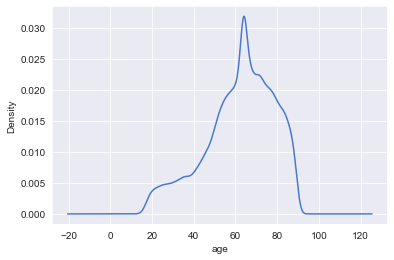

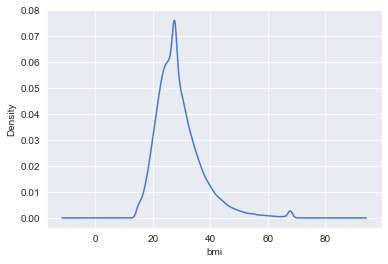

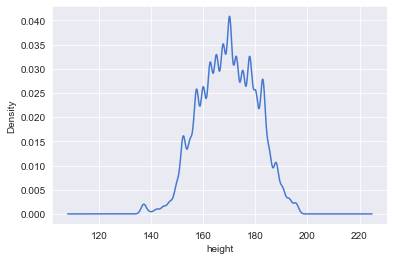

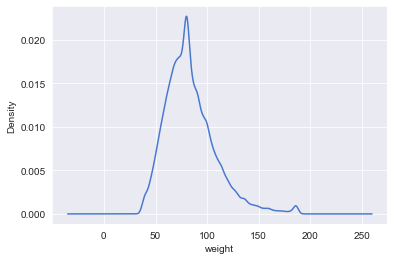

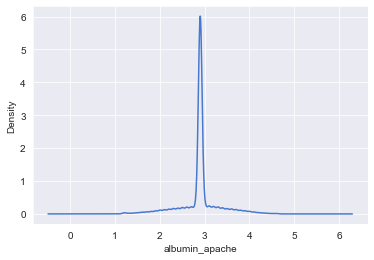

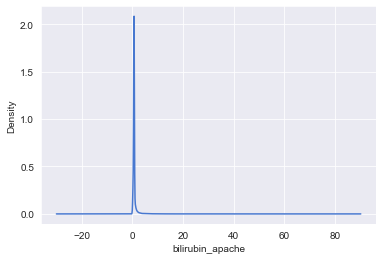

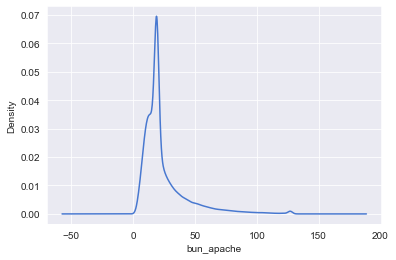

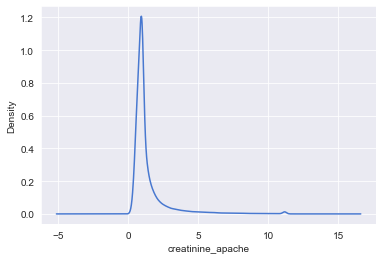

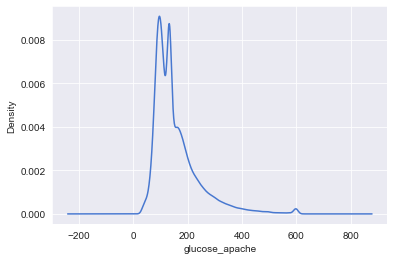

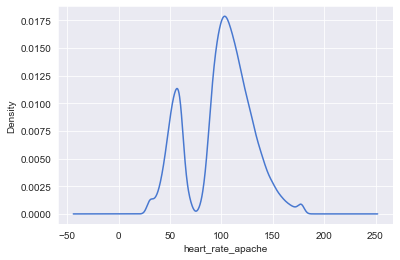

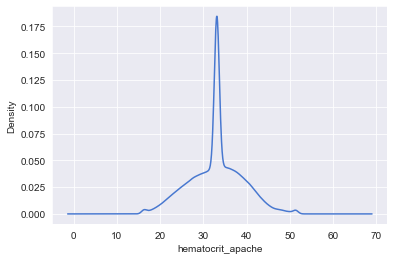

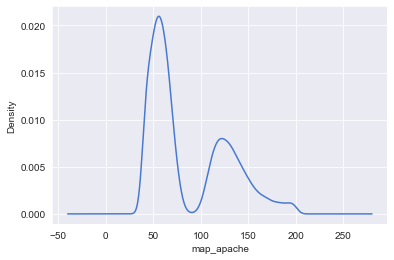

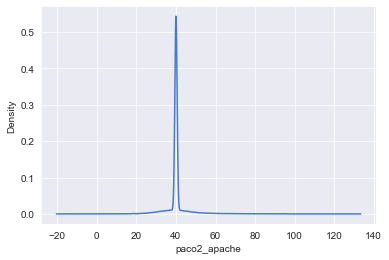

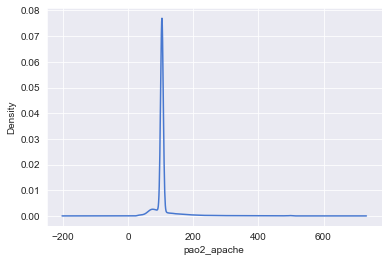

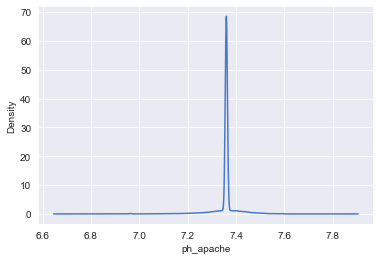

In [269]:
for col in num_df.loc[:, plot_cols[:15]].columns:
    num_df[col].plot.kde()
    plt.xlabel(col)
    plt.show()

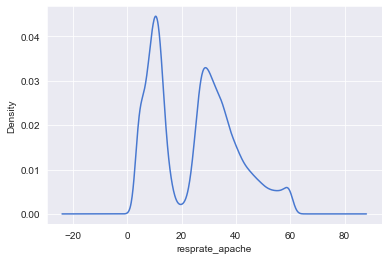

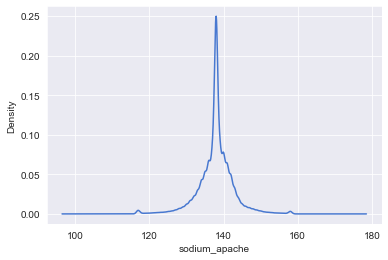

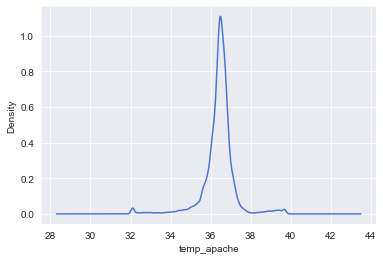

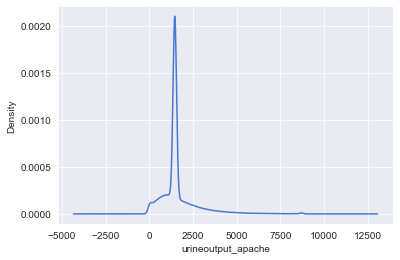

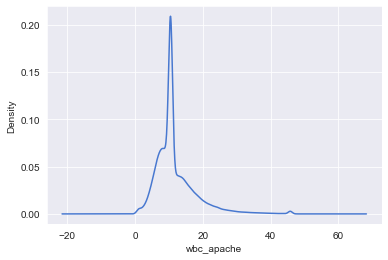

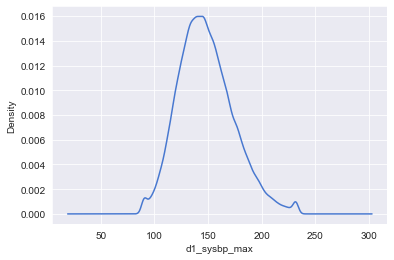

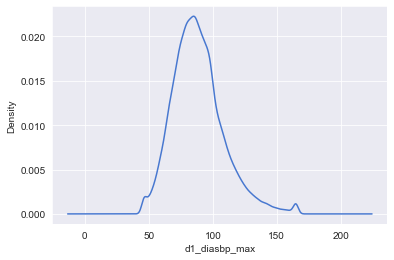

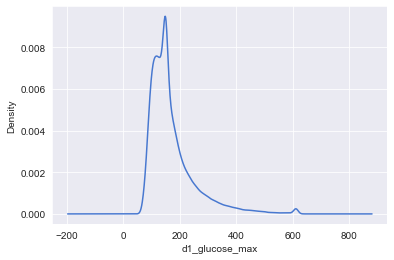

In [270]:
for col in num_df.loc[:, plot_cols[15:]].columns:
    num_df[col].plot.kde()
    plt.xlabel(col)
    plt.show()

1. Numeric columns have a variety of distribution shapes: normal, highly skewed, bi-modal, and multi-modal. 
2. Many columns have a high number of outliers (highly skewed distributions).
3. 5 columns have very low variance (< 0.01).

In [276]:
# distributions of numeric variables by class label (diabetes_mellitus= 1 or 0)

plot_df = num_df.loc[:, plot_cols]


In [277]:
plot_df.head()

,age,bmi,height,weight,albumin_apache,bilirubin_apache,bun_apache,creatinine_apache,glucose_apache,heart_rate_apache,hematocrit_apache,map_apache,paco2_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,wbc_apache,d1_sysbp_max,d1_diasbp_max,d1_glucose_max
0,68.0,22.732803,180.3,73.9,2.3,0.4,31.0,2.51,168.0,118.0,27.4,40.0,40.0,104.0,7.36,36.0,134.0,39.3,1454.976,14.10,131.0,68.0,168.0
1,77.0,27.421875,160.0,70.2,2.9,0.7,9.0,0.56,145.0,120.0,36.9,46.0,37.0,51.0,7.45,33.0,145.0,35.1,1454.976,12.70,159.0,95.0,145.0
2,25.0,31.952749,172.7,95.3,2.9,0.7,19.0,0.97,133.0,102.0,33.1,68.0,40.0,104.0,7.36,37.0,138.0,36.7,1454.976,10.47,148.0,88.0,150.0
3,81.0,22.635548,165.1,61.7,2.9,0.7,19.0,0.97,185.0,114.0,25.9,60.0,30.0,142.0,7.39,4.0,138.0,34.8,1454.976,8.00,158.0,48.0,185.0
4,19.0,27.564749,188.0,80.0,2.9,0.7,19.0,0.97,133.0,60.0,33.1,103.0,40.0,104.0,7.36,16.0,138.0,36.7,1454.976,10.47,147.0,99.0,150.0


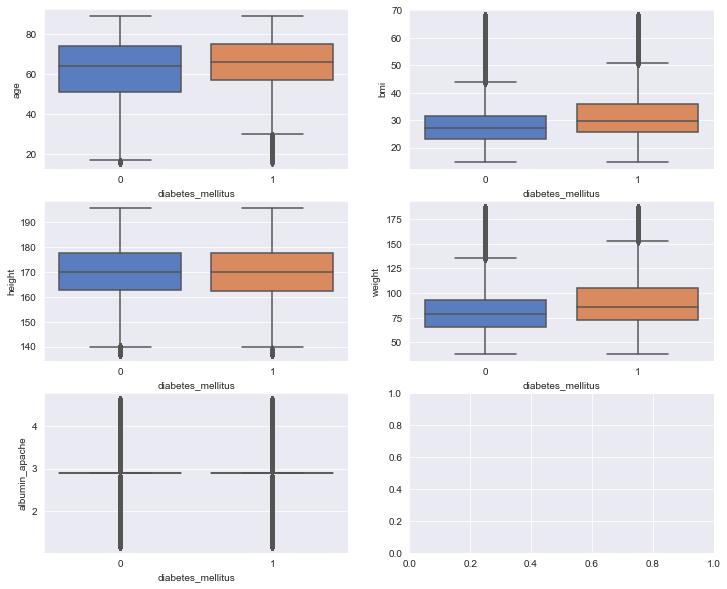

In [279]:
subplot_df = plot_df.copy().iloc[:, :5]
subplot_df['diabetes_mellitus'] = train['diabetes_mellitus']

feature_names = subplot_df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='diabetes_mellitus', y=feature_names[k], data=subplot_df, ax=axes[i][j])
            k = k + 1    
plt.show()

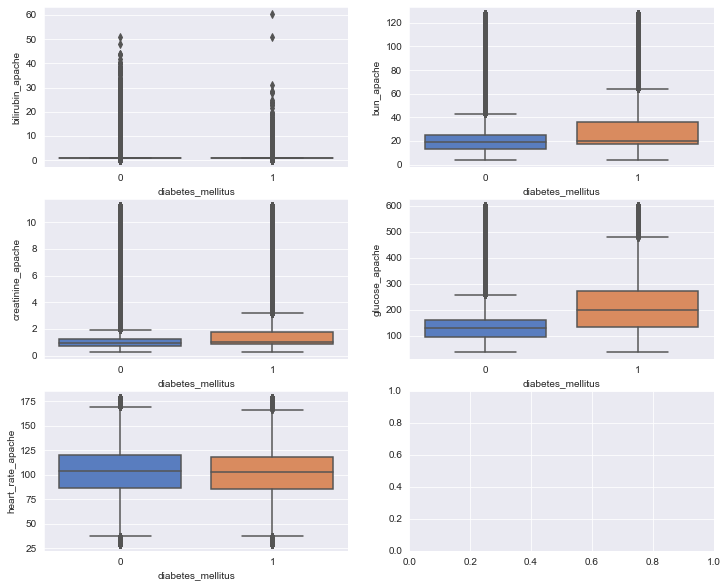

In [280]:
subplot_df = plot_df.copy().iloc[:, 5:10]
subplot_df['diabetes_mellitus'] = train['diabetes_mellitus']

feature_names = subplot_df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='diabetes_mellitus', y=feature_names[k], data=subplot_df, ax=axes[i][j])
            k = k + 1    
plt.show()

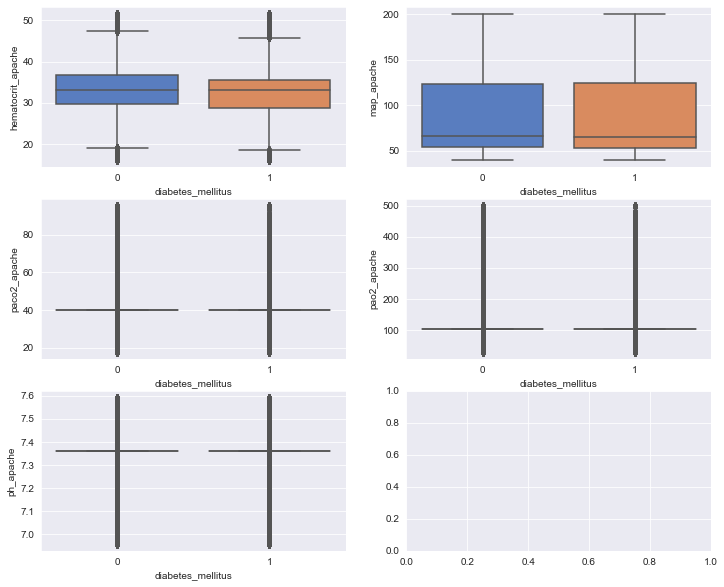

In [282]:
subplot_df = plot_df.copy().iloc[:, 10:15]
subplot_df['diabetes_mellitus'] = train['diabetes_mellitus']

feature_names = subplot_df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='diabetes_mellitus', y=feature_names[k], data=subplot_df, ax=axes[i][j])
            k = k + 1    
plt.show()

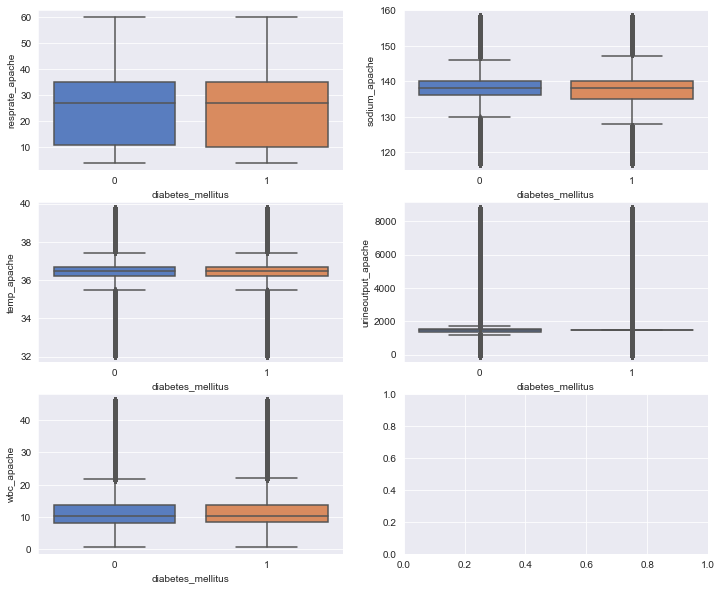

In [283]:
subplot_df = plot_df.copy().iloc[:, 15:20]
subplot_df['diabetes_mellitus'] = train['diabetes_mellitus']

feature_names = subplot_df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='diabetes_mellitus', y=feature_names[k], data=subplot_df, ax=axes[i][j])
            k = k + 1    
plt.show()

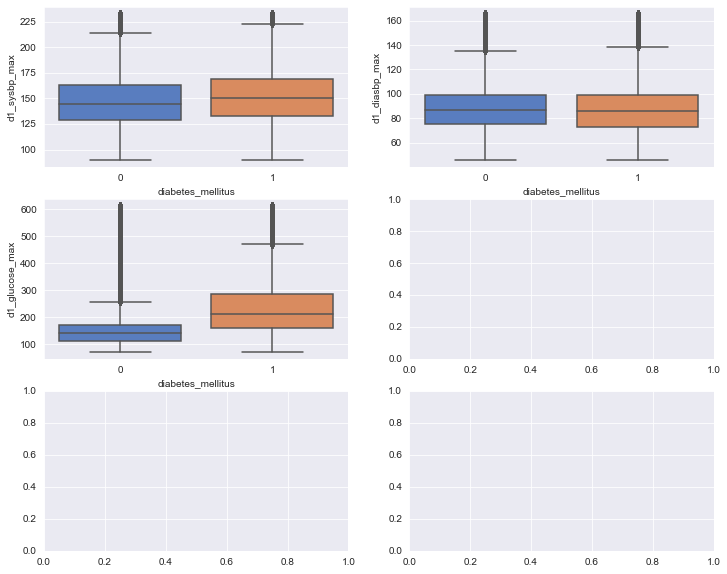

In [284]:
subplot_df = plot_df.copy().iloc[:, 20:]
subplot_df['diabetes_mellitus'] = train['diabetes_mellitus']

feature_names = subplot_df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

k = 0
for i in range(3):
    for j in range(2):
        if k != (len(feature_names) - 1):
            sns.boxplot(x='diabetes_mellitus', y=feature_names[k], data=subplot_df, ax=axes[i][j])
            k = k + 1    
plt.show()

In [289]:
# which numeric columns are linearly correlated to the class label?
num_df['diabetes_mellitus'] = train['diabetes_mellitus']

for col in num_df.columns:
    tmp_df = num_df[[col, 'diabetes_mellitus']].corr(method='pearson')
    
    if (tmp_df.iloc[0, 1] > 0.1):
        print(col, tmp_df.iloc[0, 1].round(3))
    

bmi 0.166
weight 0.153
bun_apache 0.136
creatinine_apache 0.118
glucose_apache 0.354
d1_bun_max 0.144
d1_bun_min 0.135
d1_creatinine_max 0.126
d1_creatinine_min 0.124
d1_glucose_max 0.4
d1_glucose_min 0.138
h1_glucose_max 0.251
h1_glucose_min 0.242
diabetes_mellitus 1.0


In [290]:
# which numeric columns are linearly correlated to the class label?
num_df['diabetes_mellitus'] = train['diabetes_mellitus']

for col in num_df.columns:
    tmp_df = num_df[[col, 'diabetes_mellitus']].corr(method='spearman')
    if (tmp_df.iloc[0, 1] > 0.1):
        print(col, tmp_df.iloc[0, 1].round(3))

bmi 0.172
weight 0.152
bun_apache 0.155
creatinine_apache 0.141
glucose_apache 0.314
d1_bun_max 0.165
d1_bun_min 0.149
d1_creatinine_max 0.16
d1_creatinine_min 0.146
d1_glucose_max 0.4
h1_glucose_max 0.211
h1_glucose_min 0.199
diabetes_mellitus 1.0


In [291]:
num_df[['glucose_apache', 'd1_glucose_max']].corr()

,glucose_apache,d1_glucose_max
glucose_apache,1.000000,0.914515
d1_glucose_max,0.914515,1.000000


1. weight, bun, creatinine, glucose have a small, but non-trivial degree of linear correlation as well as non-linear correlation with the class label. 

2. Notably, d1_glucose_max and glucose_apache have the highest positive correlation to diabetes diagnosis, as expected. They are also highly correlated with each other.

3. Rest of columns are not correlated to the class label.

In [293]:
num_df[['bmi', 'weight']].corr()

,bmi,weight
bmi,1.000000,0.874948
weight,0.874948,1.000000


#### Summary of conclusions:

#### Useless/redundant columns:
readmission_status

Perfect correlation:
h1_inr_min, h1_inr_max, paco2_for_ph_apache

#### Potentially useless columns:
More than 85% null:

h1_albumin_max          
h1_albumin_min        
h1_bilirubin_max       
h1_bilirubin_min     
h1_lactate_max      
h1_lactate_min        
h1_pao2fio2ratio_max   
h1_pao2fio2ratio_min    


Variance < 0.01 and VIF >> 10:

ph_apache            
d1_arterial_ph_max   
d1_arterial_ph_min  
h1_arterial_ph_max   
h1_arterial_ph_min   

#### Potentially informative columns:
* hospital_id, icu_id

* categorical ('object' datatype) columns

* weight, bun, creatinine, glucose (apache, d1 and h1 values) have a small, but non-trivial degree of linear correlation as well as non-linear correlation with the class label. d1_glucose_max is the most informative.

#### Other findings:
1. Numeric columns have a variety of distributions. Cannot use linear regression methods unless the columns are transformed to Gaussian (Normal) distribution.

2. Very high degree of multicollinearity between almost all numeric columns. This is problematic, needs correction.

3. Large number of columns have a significant percentage of nulls. 

4. Values in many *_min and *_max lab cols must be swapped (because min > max)

5. Some catgorical columns have numeric data type.

6. hospital_id, icu_id are high cardinality categoricals with heavily imbalanced levels. Needs correction.

7. Re-categorization needed for some categoricals.
